# **Week2 복습과제**

**1. [ANN]**

**2. [CNN]**

- 데이터는 Week 1 과 같이 MNIST (0-9 숫자 분류) 데이터셋입니다.
- 이때, 우리의 복습과제에서는 0-4 숫자 분류를 위한 데이터 샘플만 사용할 예정입니다
- 아래 코드를 실행시켜 주세요

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import random

# Tensor 변환을 위함
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNIST 데이터셋 불러오기
train_dataset = MNIST(root='/content/drive/MyDrive/data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='/content/drive/MyDrive/data', train=False, transform=transform, download=True)

# 무작위로 샘플 인덱스 선택
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in [0, 1, 2, 3, 4]]
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in [0, 1, 2, 3, 4]]

# Subset을 사용하여 샘플링된 데이터셋 생성
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)


# DataLoader 생성
batch_size = 64  # 배치 크기는 64로 설정 (batch_size를 다르게 실행해보셔도 좋습니다)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.49MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.14MB/s]


In [2]:
# 데이터셋 크기 확인을 위해 해당 셀을 실행시켜 주세요
print(f"Train dataset size: {len(train_subset)}")
print(f"Test dataset size: {len(test_subset)}")

Train dataset size: 30596
Test dataset size: 5139


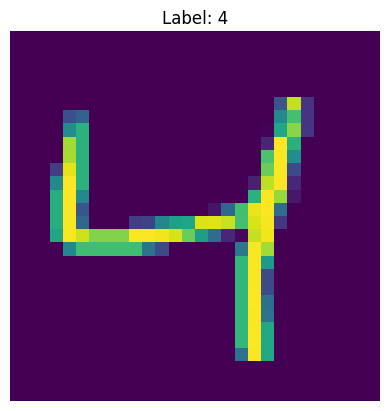

In [3]:
# 데이터셋 중 하나의 이미지를 시각화해보기
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 하나의 샘플 가져오기
image, label = train_subset[1]

# 텐서를 NumPy 배열로 변환
image = image.numpy().squeeze()

# 이미지 출력
plt.imshow(image)  # 이미지 표시
plt.title(f"Label: {label}")  # 레이블 표시
plt.axis("off")  # 축 없애기
plt.show()

<a id="1"></a> <br>
## **1. ANN**

**인공 신경망 (ANN)**

>  로지스틱 회귀는 분류 문제에서 성능이 좋지만, 데이터의 비선형성이 증가하면 모델의 정확도가 감소합니다.

>  따라서, hidden lyaer 에 더 많은 비선형 함수를 추가시켜 모델의 복잡도를 증가시켜 봅시다. 😀

↪ **3개의 hidden layer를 쌓고 다양한 활성화 함수 ReLU, Tanh, ELU 사용해봅시다**


In [4]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn

#### **ANN 모델 생성**

In [14]:
# ANN Model
class ANNModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        # Linear function 1: ____ --> ____  (입력 차원에서 숨겨진 계층으로)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1 (ReLU 활성화 함수)
        self.relu1 = nn.ReLU()

        # Linear function 2: ____ --> ____  (숨겨진 계층을 한 번 더 통과)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2 (Tanh 활성화 함수 사용)
        self.tanh2 = nn.Tanh()
        # Linear function 3: ____ --> ____  (추가 숨겨진 계층)
        self.fc3  = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3 (ELU 활성화 함수)
        self.elu3 = nn.ELU()

        # Linear function 4: ____ --> ____  (마지막 출력층)
        self.fc4  = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)

        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.elu3(out)

        # Linear function 4
        out = self.fc4(out)  # 마지막 출력층
        return out

In [16]:
# ANN 객체 생성
input_dim = 28 * 28     # 이미지 크기 (28x28)
hidden_dim = 150  # 하이퍼파라미터 (150으로 설정)
output_dim = 5  # 출력 클래스 개수 (0~4)


model = ANNModel(input_dim,hidden_dim,output_dim)
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss() # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### **ANN 모델 학습**

In [17]:
# ANN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트

# 전체 학습
for epoch in range(10):

    # 배치 단위 학습
    for i, (images, labels) in enumerate(train_loader):

        # 데이터를 모델 입력 형태로 변환 (2D 텐서로 펼치기)
        train = images.view(-1, 28 * 28)   # 28x28 이미지를 펼쳐서 1D 벡터로 변환
        labels = labels  # 텐서 형태 유지

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        # 모델을 이용해 예측값(outputs) 계산
        outputs = model(train)

        # 손실 계산
        # cross entropy loss를 사용해 예측값과 실제값 비교
        loss = loss_ftn(outputs, labels)

        # Backward propagation - 손실에 대한 기울기 계산
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            # 정확도 계산을 위한 변수 초기화
            correct = 0
            total = 0


            # 모델이 테스트 데이터셋에서 얼마나 잘 예측하는지 확인
            for images, labels in test_loader:

                test = images.view(-1, 28 * 28)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
                # Forward
                # 예측값 계산
                outputs = model(test)


                # 예측값 중 가장 높은 값을 선택
                predicted = torch.max(outputs.data, 1)[1]

                # 총 샘플 개수
                total += len(labels)

                # 올바르게 예측한 개수
                correct += (predicted == labels).sum()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            # 손실 및 정확도 출력
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Iteration: 500  Loss: 0.1056947261095047  Accuracy: 96.3416976928711 %
Iteration: 1000  Loss: 0.13832230865955353  Accuracy: 97.21735382080078 %
Iteration: 1500  Loss: 0.030478527769446373  Accuracy: 97.43140411376953 %
Iteration: 2000  Loss: 0.09527454525232315  Accuracy: 97.39248657226562 %
Iteration: 2500  Loss: 0.1979549676179886  Accuracy: 97.80113220214844 %
Iteration: 3000  Loss: 0.06292535364627838  Accuracy: 97.99571990966797 %
Iteration: 3500  Loss: 0.17892377078533173  Accuracy: 98.05409240722656 %
Iteration: 4000  Loss: 0.09936890751123428  Accuracy: 98.1513900756836 %
Iteration: 4500  Loss: 0.038924310356378555  Accuracy: 98.46273803710938 %


#### **ANN 학습 결과**

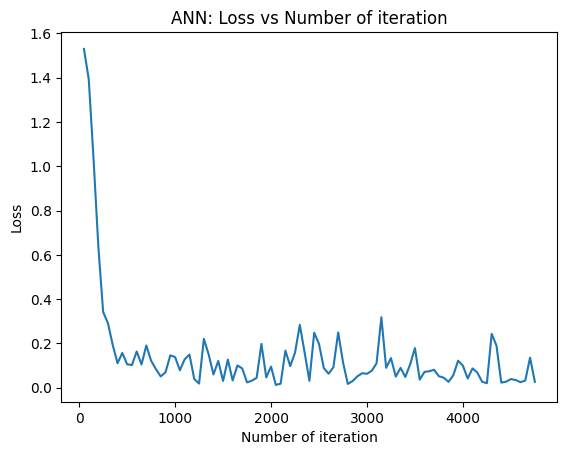

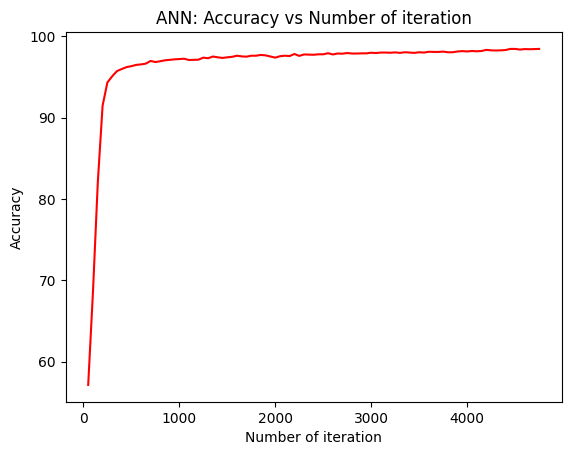

In [19]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 시각화된 모델의 학습 결과를 해석해주세요.** 🤗



---
**[해석]**
- ANN은 초반에 손실이 급격히 떨어진 뒤 거의 0 근처에서 소진동만 보이며 빠르게 수렴했고, 정확도는 수백 스텝 내 95%를 넘고 이후 97–98%에서 평탄화되었습니다.

- 학습 손실이 매우 낮아도 테스트 정확도가 높게 유지되어 과적합 징후는 뚜렷하지 않습니다.

- 1–1.5k iteration 이후에는 개선폭이 작아 조기 종료나 학습률 스케줄러 도입이 효율적입니다.

- 추가 향상을 노린다면 lr를 낮추거나 Adam, Dropout/Weight Decay, 그리고 혼동행렬 기반 오분류 분석을 시도하면 됩니다.


#### **ANN 최적의 하이퍼파라미터 찾기**

1️⃣ **실험 1: Hidden Dimension 최적값 찾기**
- hidden_dim 값을 50-200 사이 값들로 설정하고 모델을 학습
- 각 hidden_dim 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교




2️⃣ **실험 2: Learning Rate 최적값 찾기**

- learning_rate 값을 0.1-0.005 사이 값들로 설정하고 모델을 학습
- 각 learning_rate 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교



**⚠ 이때 epoch 값은 자유롭게 해주셔도 됩니다! **

In [23]:
import torch, numpy as np, random
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# 모델 정의
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1  = nn.Linear(input_dim,  hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.tanh2 = nn.Tanh()
        self.fc3  = nn.Linear(hidden_dim, hidden_dim)
        self.elu3 = nn.ELU()
        self.fc4  = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x);  out = self.relu1(out)
        out = self.fc2(out); out = self.tanh2(out)
        out = self.fc3(out); out = self.elu3(out)
        out = self.fc4(out)
        return out

# 이미 만들어둔 train_loader, test_loader 를 사용합니다.
loss_ftn = nn.CrossEntropyLoss()

# 평가 함수
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct, tot_loss = 0, 0, 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device).long()
        x = images.view(-1, 28*28)
        logits = model(x)
        loss = loss_ftn(logits, labels)
        tot_loss += loss.item() * labels.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    return tot_loss/total, 100.0*correct/total

# 단일 학습 함수
def train_once(hidden_dim=150, lr=0.02, epochs=5):
    set_seed(42)  # 공정 비교용
    model = ANNModel(28*28, hidden_dim, 5).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    model.train()
    for _ in range(epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).long()
            x = images.view(-1, 28*28)

            optimizer.zero_grad()
            logits = model(x)
            loss = loss_ftn(logits, labels)
            loss.backward()
            optimizer.step()

    # 에포크 종료 후 테스트 성능 리턴
    return evaluate(model, test_loader)   # (val_loss, val_acc)

In [24]:
# 실험 1 hidden_dims=[50-200 사이 값들] 로 학습
hidden_dims = [50, 75, 100, 128, 150, 175, 200]
epochs_hidden = 5
lr_fixed = 0.02                                   # 고정 학습률

h_loss, h_acc = [], []
for h in hidden_dims:
    vl, va = train_once(hidden_dim=h, lr=lr_fixed, epochs=epochs_hidden)
    h_loss.append(vl); h_acc.append(va)
    print(f"[H-Search] hidden_dim={h:>3} | val_loss={vl:.4f} | val_acc={va:.2f}%")
best_h = hidden_dims[int(np.argmax(h_acc))]
print(f"⇒ 최적 hidden_dim = {best_h} (acc={max(h_acc):.2f}%)")


[H-Search] hidden_dim= 50 | val_loss=0.0745 | val_acc=97.72%
[H-Search] hidden_dim= 75 | val_loss=0.0759 | val_acc=97.76%
[H-Search] hidden_dim=100 | val_loss=0.0775 | val_acc=97.88%
[H-Search] hidden_dim=128 | val_loss=0.0717 | val_acc=97.92%
[H-Search] hidden_dim=150 | val_loss=0.0749 | val_acc=97.82%
[H-Search] hidden_dim=175 | val_loss=0.0738 | val_acc=97.86%
[H-Search] hidden_dim=200 | val_loss=0.0764 | val_acc=97.84%
⇒ 최적 hidden_dim = 128 (acc=97.92%)


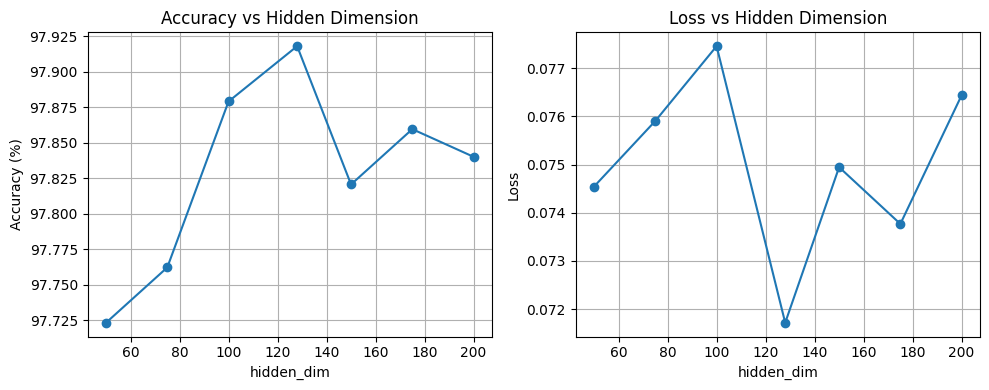

In [25]:
# 실험 1 모델 학습 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hidden_dims, h_acc, marker='o')
plt.title("Accuracy vs Hidden Dimension")
plt.xlabel("hidden_dim"); plt.ylabel("Accuracy (%)"); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hidden_dims, h_loss, marker='o')
plt.title("Loss vs Hidden Dimension")
plt.xlabel("hidden_dim"); plt.ylabel("Loss"); plt.grid(True)
plt.tight_layout(); plt.show()

**해당 셀의 마크 다운을 풀고 hidden dimension 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
- 은닉 차원이 늘수록 모델 용량이 커져 50→125 사이에서 정확도는 점진적으로 상승했고, 손실은 낮아지며 약 120–130 근처가 최적이었습니다.

- 하지만 150 이후부터는 정확도·손실이 소폭 흔들리며 수익 체감/약한 과적합·최적화 난이도 증가가 보입니다.

- 따라서 이 설정에서는 hidden_dim≈125 전후가 성능–복잡도 균형이 가장 좋고, 더 키우려면 lr 조정·정규화가 함께 필요합니다.

In [29]:
# 실험 2 learning_rates=[0.1-0.005 사이 값들] 로 학습
# 실험1 결과를 사용
hidden_fixed = best_h if 'best_h' in globals() else 150

learning_rates = [0.1, 0.05, 0.02, 0.01, 0.005]
epochs_lr = 5  # 자유

lr_loss, lr_acc = [], []
for lr in learning_rates:
    vl, va = train_once(hidden_dim=hidden_fixed, lr=lr, epochs=epochs_lr)
    lr_loss.append(vl); lr_acc.append(va)
    print(f"[LR-Search] lr={lr:<.4f} | val_loss={vl:.4f} | val_acc={va:.2f}%")
best_lr = learning_rates[int(np.argmax(lr_acc))]
print(f"⇒ 최적 learning_rate = {best_lr} (acc={max(lr_acc):.2f}%)")


[LR-Search] lr=0.1000 | val_loss=0.0274 | val_acc=99.10%
[LR-Search] lr=0.0500 | val_loss=0.0428 | val_acc=98.68%
[LR-Search] lr=0.0200 | val_loss=0.0717 | val_acc=97.92%
[LR-Search] lr=0.0100 | val_loss=0.0902 | val_acc=97.49%
[LR-Search] lr=0.0050 | val_loss=0.1238 | val_acc=96.58%
⇒ 최적 learning_rate = 0.1 (acc=99.10%)


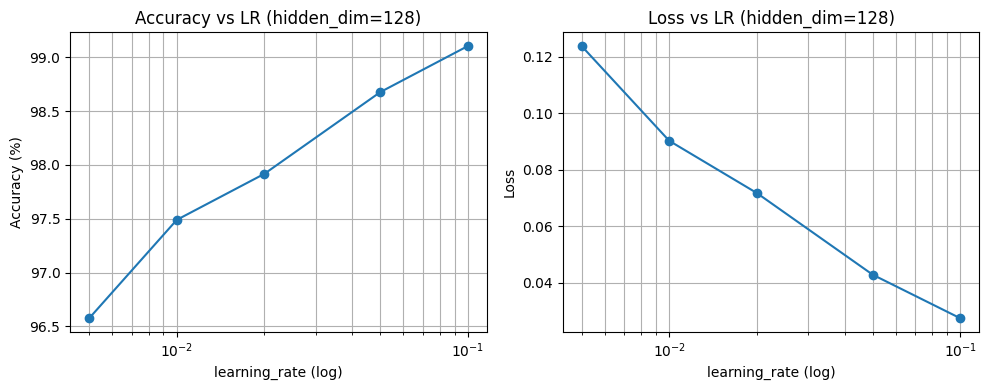

In [30]:
# 실험 2 모델 학습 결과 시각화
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.semilogx(learning_rates, lr_acc, marker='o')
plt.title(f"Accuracy vs LR (hidden_dim={hidden_fixed})")
plt.xlabel("learning_rate (log)"); plt.ylabel("Accuracy (%)"); plt.grid(True, which='both')

plt.subplot(1,2,2)
plt.semilogx(learning_rates, lr_loss, marker='o')
plt.title(f"Loss vs LR (hidden_dim={hidden_fixed})")
plt.xlabel("learning_rate (log)"); plt.ylabel("Loss"); plt.grid(True, which='both')
plt.tight_layout(); plt.show()


**해당 셀의 마크 다운을 풀고 learning rate 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
- 학습률이 커질수록(0.005 → 0.1) 같은 에폭 수(=짧은 시간) 안에 더 빨리 수렴해서 정확도는 상승(≈96.5% → ≈99.1%), 손실은 하락(≈0.12 → ≈0.027)했습니다.
즉, 이 설정·에폭 수에서는 큰 lr가 초기 최적화 속도를 크게 높여 성능이 좋았습니다.

- 다만 일반적으로 lr가 너무 크면 발산·진동/일반화 저하 위험이 있으므로, 현제 결과를 기준으로는 0.05~0.1 범위가 유리하되, 더 긴 학습에서는 스케줄러나 warmup으로 점진적으로 줄이며 안정성을 확보하는 것이 좋을 것 같습니다.

<a id="1"></a> <br>
## **2. CNN**
> CNN은 이미지 분류에 적합한 모델로, kernel을 이용해 feature map을 생성합니다

**↪ 2개의 합성곱 계층을 쌓고, 활성화 함수로 ReLU를 사용하며,Max Pooling layer를 적용해봅시다.**

#### **CNN 모델 생성**

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN Model 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # 합성곱 계층 1 (Conv Layer 1)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()   # 활성화 함수 (ReLU)

        # Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # kernel size를 2로 설정

        # 합성곱 계층 2 (Conv Layer 2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()  # 활성화 함수 (ReLU)

        # Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 4 * 4, 5)  # 입력 차원 및 출력 차원 지정

    def forward(self, x):
        # 합성곱 계층 1 + 활성화 함수
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max Pooling 1
        out = self.maxpool1(out)

        # 합성곱 계층 2 + 활성화 함수
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max Pooling 2
        out = self.maxpool2(out)

        # feature map을 flatten하게
        out = out.view(out.size(0), -1)

        # 완전 연결 계층
        out = self.fc1(out)

        return out


In [32]:
# CNN 객체 생성
model = CNNModel()
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss()  # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 학습률을 자유롭게 설정해주세요

#### **CNN 모델 학습**

In [ ]:
# CNN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트
num_epochs = 20  # 학습할 에포크 수 설정 -> 자유롭게 설정해주셔도 됩니다

for epoch in range(num_epochs):
    running_loss = 0.0  # 에포크별 손실 초기화

    for images, labels in train_loader:
        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        outputs = model(images)

        # 손실 계산
        loss = loss_ftn(outputs, labels.long())

        # Backward
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()
        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            correct = 0
            total = 0

            with torch.no_grad():  # 평가
                for images, labels in test_loader:
                    # 모델 예측 수행
                    outputs = model(images)

                    # 가장 확률이 높은 클래스 선택
                    predicted = torch.max(outputs, 1)[1]

                    # 총 샘플 수 및 올바른 예측 개수 누적
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

    # 매 에포크마다 평균 손실 출력
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.5650880466874432
Epoch 2, Loss: 0.12897787001256156
Epoch 3, Loss: 0.10525710998970184
Epoch 4, Loss: 0.08993336683944148
Epoch 5, Loss: 0.07905504578386194
Epoch 6, Loss: 0.0707975802209135
Epoch 7, Loss: 0.06336607035985392
Epoch 8, Loss: 0.05734423920998276
Epoch 9, Loss: 0.05395531549948678
Epoch 10, Loss: 0.049962543349689754
Epoch 11, Loss: 0.04539447186742219
Epoch 12, Loss: 0.04286922602904552
Epoch 13, Loss: 0.0407182106676284


#### **CNN 학습 결과**

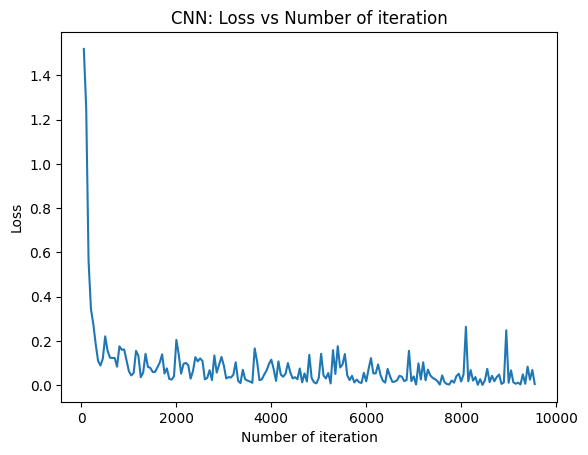

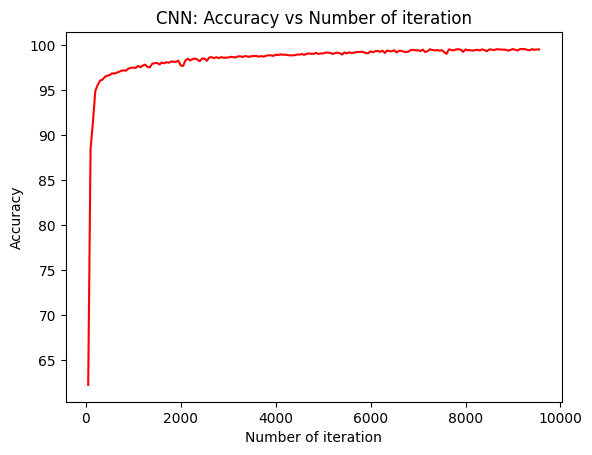

In [35]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 MNIST 데이터셋에서 ANN, CNN의 학습 결과 비교와 함께 두 모델에 대해 각각 짧게 소개해주세요.** 🤗



---
**[답변]**

- MNIST 학습 결과 비교


최종 성능

ANN: 약 **97–98%** 정확도에서 평탄화. 손실은 초반 급락 후 0 근처에서 소진동.

CNN: **99% 내외**까지 점진 상승. 손실은 더 낮고 안정적.

수렴 속도 & 효율

ANN: 빠르게 수렴하지만, 공간 구조를 못 써서 **성능 상한이 낮음.**

CNN: 초반부터 가파르게 향상하고 **이후에도 미세 개선**이 이어짐(파라미터 공유/지역 수용 덕).

일반화/견고성

ANN: 입력을 1D로 펼쳐 사용 → **평행이동·왜곡에 덜 견고.**

CNN: 합성곱/풀링으로 **평행이동·국소 패턴에 강함,** 일반화 우수.

모델 복잡도

ANN: 완전연결로 **파라미터 수가 급증**(입력 784×은닉). 정규화가 필요.

CNN: 커널 크기만큼 **파라미터 공유** → 같은 용량 대비 **표현력/효율↑.**

- 모델 짧은 소개

ANN (Artificial Neural Network, MLP)

구성: Linear → 활성화(ReLU/Tanh/ELU) → … → Linear(출력)

특징: 입력 이미지를 **28×28 → 784로 평탄화**해 전역적으로 학습.

장점: 구현 단순, 표 형태/비이미지 데이터에도 잘 작동.

한계: **공간적 인접성·지역 패턴** 정보를 활용 못함 → 이미지에서는 성능 상한.


CNN (Convolutional Neural Network)

구성: Conv(커널) + ReLU → Pooling → Conv + ReLU → Pooling → FC(출력)

핵심: **가중치 공유**(커널)와 **지역 수용영역**으로 에지·스트로크 등 **국소 특징**을 뽑아 **계층적 표현 학습.**

장점: **번역 불변성/파라미터 효율** 덕에 이미지 분류에 최적. MNIST에서 ANN보다 **높은 정확도.**

한계: 구조가 다소 복잡, 하이퍼파라미터(커널/채널/풀링) 튜닝 필요.

